<h1><center>Named Entity Recognition Model using  Clinical BERT </center></h1>
<h4><center>Final Project W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook, we will look at implementing various BERT models to understand the significance of domain specific contexts with respect to fine tuning NER task.

- The various BERT models used in the notebook are listed below.

__BERT:__ 
>"BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", by Devlin/Chang/Lee/Toutanova, Google AI Language)

__BioBERT:__ 
>A pre-trained biomedical language representation model for biomedical text mining by Jinhyuk Lee, Wonjin Yoon, Sungdong Kim, Donghyeon Kim, Sunkyu Kim, Chan Ho So, Jaewoo Kang

__SciBERT:__
>A Pretrained Language Model for Scientific Text by Iz Beltagy, Kyle Lo, Arman Cohan

__ClinicalBert:__
>Modeling Clinical Notes and Predicting Hospital Readmission by Kexin Huang, Jaan Altosaar, Rajesh Ranganath

>Publicly Available Clinical BERT Embeddings by Emily Alsentzer, John R. Murphy, Willie Boag, Wei-Hung Weng, Di Jin, Tristan Naumann, Matthew B. A. McDermott


Models used and their corresponding Corpora used:


__Base Bert Cased -__  

>Wikipedia + BookCorpus

__BioBert Cased with PubMed and PMC - __

>English Wikipedia, General BooksCorpus, General PubMed Abstracts, PMC Full-text articles

__SciBert Cased -__

>1.14M papers from Semantic Scholar (Ammar et al., 2018)

__biobert_pretrain_output_all_notes_150000__

>MIMIC text from all note types on BioBert


__biobert_pretrain_output_disch_100000__

>MIMIC text from all discharge summaries on BioBert


We look at the effect of also fine-tuning BERT layers which are pre-trained with clinical context. 


### 1. Data



In [8]:
!tail -20 'ner_dataset.csv'

",",",",O
M.D,NNP,O
JA25,NNP,O
Attending:,NNP,O
SYDNEY,NNP,O
DUESTERHAUS,NNP,O
",",",",O
M.D,NNP,O
MG85,NNP,O
EQ681/3978,NNP,O
Batch:,NNP,O
37609,CD,O
Index,NNP,O
No,NNP,O
FHOW8875S8,NNP,O
D:,NNP,O
6/10,CD,O
T:,NNP,O
1/22,CD,O
[report_end],NN,O


What we have are words, their corresponding POS and their NER tags

### 3. Importing various libraries needed for the notebook

We start with some imports, adding the data and bert path, and then completing all imports.

In [9]:
!pip install seqeval[gpu]

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange


from datetime import datetime
import os
import sys
import zipfile



In [11]:

# Define maximal length of input 'sentences' (post tokenization) and batch sizes.
max_word = 40
max_length = 64
MAX_LEN = 128
bs = 32

In [12]:

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [14]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

### Tokenizer

We first start by defining and exploring the BERT tokenizer:

In [15]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

100%|██████████| 213450/213450 [00:00<00:00, 900373.91B/s]


Let's play with the tokenizer. You will see that the tokenizer occasionally splits one word into multiple tokens. Why is that the case? Because the approach of using word pieces reduces the vocabulary size and/or number of unknown words.

Here is one example:

In [16]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [17]:
tokenizer.convert_tokens_to_ids([
    '[CLS]', 'i', "'",'ll', 'learn','to','swim','in','123', '##42', 'years', '.'])

[101, 178, 112, 1325, 3858, 1106, 11231, 1107, 13414, 23117, 1201, 119]

In [18]:
tokenizer.convert_ids_to_tokens([20958])

['Faye']

Good. Now we are ready to use it for our text.

### 4. Building Sentences


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

In [19]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [20]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [21]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': 1}

In [22]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

We are now ready to convert the text file into appropriate arrays:

In [23]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open('ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
word_count = 0
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (word_count >= max_word -1):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word
        word_count = 0
    
    word_count += 1
    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

What did this do?

In [24]:
print(sentLengthList[4])

47


In [25]:
print(bertSentenceIDs[4])

[101, 2103, 1115, 1123, 2555, 1125, 1151, 2221, 107, 107, 1105, 1175, 1127, 1185, 2091, 8661, 2879, 1895, 27631, 13066, 1224, 1608, 1109, 5884, 1104, 27631, 20702, 1166, 1103, 1736, 1104, 1103, 1480, 107, 107, 1170, 1134, 1553, 1131, 1108, 2752, 1171, 1106, 2001, 10805, 8643, 3875, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
print(sentenceTokenList[4])

['[CLS]', 'reported', 'that', 'her', 'foot', 'had', 'been', 'blue', '"', '"', 'and', 'there', 'were', 'no', 'Do', '##pp', '##ler', '##able', 'pulses', 'Color', 'later', 'returned', 'The', 'absence', 'of', 'pulses', 'persisted', 'over', 'the', 'course', 'of', 'the', 'night', '"', '"', 'after', 'which', 'point', 'she', 'was', 'referred', 'back', 'to', 'La', '##rg', '##rine', 'Medical', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [27]:
print(nerTokenList[4])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [28]:
print(bertMasks[4])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [29]:
print(bertSequenceIDs[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([   5.,    0.,    7.,    0.,    0.,   21.,    0.,    0.,   31.,
           0.,   44.,    0.,    0.,   51.,    0.,    0.,   69.,    0.,
          85.,    0.,    0.,  108.,    0.,    0.,  128.,    0.,  149.,
           0.,    0.,  163.,    0.,    0.,  169.,    0.,    0.,  178.,
           0.,  201.,    0.,    0.,  208.,    0.,    0.,  228.,    0.,
         228.,    0.,    0.,  224.,    0.,    0.,  222.,    0.,  192.,
           0.,    0.,  179.,    0.,    0.,  186.,    0., 4412.]),
 array([40.        , 40.37096774, 40.74193548, 41.11290323, 41.48387097,
        41.85483871, 42.22580645, 42.59677419, 42.96774194, 43.33870968,
        43.70967742, 44.08064516, 44.4516129 , 44.82258065, 45.19354839,
        45.56451613, 45.93548387, 46.30645161, 46.67741935, 47.0483871 ,
        47.41935484, 47.79032258, 48.16129032, 48.53225806, 48.90322581,
        49.27419355, 49.64516129, 50.01612903, 50.38709677, 50.75806452,
        51.12903226, 51.5       , 51.87096774, 52.24193548, 52.6129032

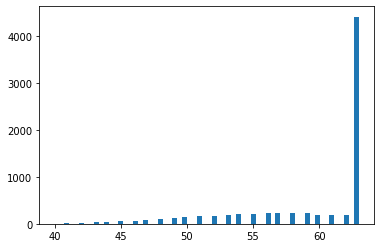

In [30]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

An average sentence length of ~25 (incl. extra tokens!) is roughly expected. It turns out that on these types of corpora an average sentence length of ~20 tends to be seen. The big spike on the right obviously corresponds to all sentences that we had to truncate. 

Next, we analyze the distribution of ner labels. First, we assign numbers to the labels and look at the overall distribution:

In [31]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f834b8c7ba8>]],
      dtype=object)

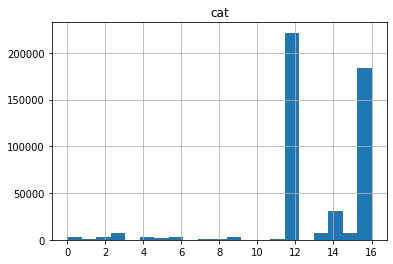

In [32]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 16+... Let's see which labels these label numbers corresponds to:

In [33]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-do,0,3520
1,B-du,1,485
2,B-f,2,3171
3,B-m,3,7443
4,B-mo,4,2664
5,B-r,5,1479
6,I-do,6,3146
7,I-du,7,1020
8,I-f,8,1109
9,I-m,9,3321


Interesting. 12 corresponds to 'O', and all 'extension' labels (i.e., those that were not part of the original data) occur at 13+. 

'O' is the most common token - by far.

### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [34]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 13]['occurences'].sum()

O_occurences/All_occurences

12    0.885908
Name: occurences, dtype: float64

So **88.5%** is the baseline

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [35]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



In [36]:
tr_inputs, val_inputs, tr_tags, val_tags, tr_sen, val_sen, tr_ner, val_ner = train_test_split(bertSentenceIDs, 
                                                                                              nerLabels,sentenceTokenList, 
                                                            nerTokenList,random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(bertMasks, bertSentenceIDs,
                                             random_state=2018, test_size=0.1)

In [37]:
print(tr_masks[6])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
print(tr_inputs[6])

[101, 1132, 15498, 125, 5135, 13335, 8643, 131, 1109, 5351, 1144, 170, 1607, 1104, 17972, 17972, 1335, 1148, 107, 107, 1119, 1108, 1113, 1117, 1313, 13753, 1104, 151, 2101, 3048, 26825, 1134, 1108, 1406, 2338, 4841, 12734, 13064, 3828, 1112, 1218, 1112, 1126, 26825, 7989, 3418, 2279, 1104, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [39]:
tr_tags[6]

array([13, 12, 12, 12, 12, 16, 16, 16, 12, 12, 12, 12, 12, 12,  5,  5, 12,
       12, 12, 16, 12, 12, 12, 12, 12, 12, 12,  3, 16, 16,  9, 12, 12,  0,
        6,  4, 16, 16,  2, 12, 12, 12, 12,  3,  0,  6, 12, 12, 15, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int8)

In [40]:
print(sentenceTokenList[6])

['[CLS]', 'on', 'the', '2', 'of', 'September', 'PA', '##ST', 'S', '##UR', '##GI', '##CA', '##L', 'H', '##IS', '##TO', '##R', '##Y', ':', 'Notable', 'for', 'the', 'above', '"', '"', 'as', 'well', 'as', 'de', '##bri', '##de', '##ments', 'of', 'her', 'toe', 'am', '##putation', 'wound', 'site', 'AD', '##MI', '##SS', '##ION', 'ME', '##DI', '##CA', '##TI', '##ON', '##S', ':', 'Cola', '##ce', '100', 'mg', 'b', '.', 'i', '.', 'd', '"', '"', 'insulin', '[SEP]', '[PAD]']


In [41]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long, device=device)
val_tags = torch.tensor(val_tags, dtype=torch.long, device=device)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [42]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [43]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

100%|██████████| 404400730/404400730 [00:20<00:00, 20119949.17B/s]


In [44]:
print(model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [45]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [46]:
model.cuda();

In [47]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [48]:
epochs = 20
max_grad_norm = 1.0

train_loss_bert = []
evaluation_loss_bert = []
f1score_bert = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss_bert.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss_bert.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score_bert.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.29479472293249237
Validation loss: 0.07548612371707956
Validation Accuracy: 0.9620314378004808


Epoch:   5%|▌         | 1/20 [02:40<50:40, 160.02s/it]

F1-Score: 0.7843031123139377
Recall: 0.7879282218597063
Train loss: 0.06817662082965623
Validation loss: 0.05264149645032982
Validation Accuracy: 0.9751258263221154


Epoch:  10%|█         | 2/20 [05:19<47:55, 159.78s/it]

F1-Score: 0.8350240256273358
Recall: 0.8275132275132275
Train loss: 0.046550220628909025
Validation loss: 0.04976194530415038
Validation Accuracy: 0.9814312274639424


Epoch:  15%|█▌        | 3/20 [07:57<45:07, 159.27s/it]

F1-Score: 0.8481210855949896
Recall: 0.8223684210526315
Train loss: 0.035629303618312166
Validation loss: 0.04601304139941931
Validation Accuracy: 0.9775265424679488


Epoch:  20%|██        | 4/20 [10:34<42:20, 158.76s/it]

F1-Score: 0.860249270750464
Recall: 0.8469973890339425
Train loss: 0.0275414829844194
Validation loss: 0.04954494892929991
Validation Accuracy: 0.9799789037459936


Epoch:  25%|██▌       | 5/20 [13:12<39:36, 158.42s/it]

F1-Score: 0.8641390205371249
Recall: 0.845005149330587
Train loss: 0.021613485687434392
Validation loss: 0.051526793356363974
Validation Accuracy: 0.9783716446314102


Epoch:  30%|███       | 6/20 [15:50<36:54, 158.20s/it]

F1-Score: 0.8697501329080277
Recall: 0.8583420776495279
Train loss: 0.017547504793216973
Validation loss: 0.05406322221582135
Validation Accuracy: 0.9755358573717948


Epoch:  35%|███▌      | 7/20 [18:28<34:18, 158.36s/it]

F1-Score: 0.8677248677248677
Recall: 0.8523908523908524
Train loss: 0.014575771722607139
Validation loss: 0.054932583666717015
Validation Accuracy: 0.9711428911258012


Epoch:  40%|████      | 8/20 [21:07<31:41, 158.47s/it]

F1-Score: 0.8615782664941786
Recall: 0.8287705326032853
Train loss: 0.011820973181805763
Validation loss: 0.056474435764054455
Validation Accuracy: 0.9834563426482372


Epoch:  45%|████▌     | 9/20 [23:45<29:00, 158.27s/it]

F1-Score: 0.8721084817867588
Recall: 0.8608923884514436
Train loss: 0.009891027861641128
Validation loss: 0.06145400802294413
Validation Accuracy: 0.9830071864983975


Epoch:  50%|█████     | 10/20 [26:23<26:21, 158.15s/it]

F1-Score: 0.8645533141210373
Recall: 0.8414074451810301
Train loss: 0.008426304917641302
Validation loss: 0.06885554369849463
Validation Accuracy: 0.980476575020032


Epoch:  55%|█████▌    | 11/20 [29:01<23:42, 158.05s/it]

F1-Score: 0.8676202860858258
Recall: 0.8386123680241327
Train loss: 0.007395798723341377
Validation loss: 0.06950846058316529
Validation Accuracy: 0.9816565880408654


Epoch:  60%|██████    | 12/20 [31:39<21:05, 158.13s/it]

F1-Score: 0.8746666666666666
Recall: 0.8658922914466737
Train loss: 0.006432624477220002
Validation loss: 0.06748892452257375
Validation Accuracy: 0.9797347631209936


Epoch:  65%|██████▌   | 13/20 [34:17<18:26, 158.04s/it]

F1-Score: 0.8746371074162047
Recall: 0.8572167615106053
Train loss: 0.005313168219963786
Validation loss: 0.07483153712625305
Validation Accuracy: 0.9813201121794872


Epoch:  70%|███████   | 14/20 [36:55<15:48, 158.04s/it]

F1-Score: 0.8676160337552742
Recall: 0.8496900826446281
Train loss: 0.004855051274484209
Validation loss: 0.077061434276402
Validation Accuracy: 0.9769177559094552


Epoch:  75%|███████▌  | 15/20 [39:33<13:09, 158.00s/it]

F1-Score: 0.8578052550231839
Recall: 0.8218163869693978
Train loss: 0.004332744401948023
Validation loss: 0.08010867944297691
Validation Accuracy: 0.9876677684294872


Epoch:  80%|████████  | 16/20 [42:11<10:31, 157.99s/it]

F1-Score: 0.8809651474530831
Recall: 0.8767342582710779
Train loss: 0.003943345391536926
Validation loss: 0.0760135321567456
Validation Accuracy: 0.9876959385016025


Epoch:  85%|████████▌ | 17/20 [44:50<07:54, 158.26s/it]

F1-Score: 0.872408293460925
Recall: 0.8609653725078699
Train loss: 0.0034442070538621677
Validation loss: 0.07903463183902204
Validation Accuracy: 0.9877882737379808


Epoch:  90%|█████████ | 18/20 [47:29<05:17, 158.53s/it]

F1-Score: 0.8791267305644302
Recall: 0.8689473684210526
Train loss: 0.003353199614854684
Validation loss: 0.08181284996680915
Validation Accuracy: 0.9877084585336539


Epoch:  95%|█████████▌| 19/20 [50:08<02:38, 158.86s/it]

F1-Score: 0.8764223339507806
Recall: 0.8611544461778471
Train loss: 0.0031818756907466598
Validation loss: 0.08264603178637724
Validation Accuracy: 0.9871090619991988


Epoch: 100%|██████████| 20/20 [52:47<00:00, 158.73s/it]

F1-Score: 0.8644957983193278
Recall: 0.8432377049180327


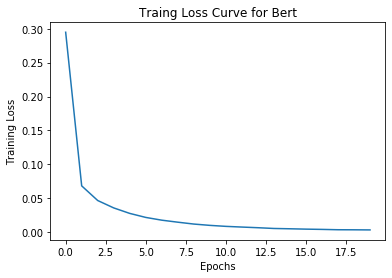

In [49]:
import matplotlib.pyplot as plt

plt.plot(train_loss_bert)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve for Bert")
plt.show()

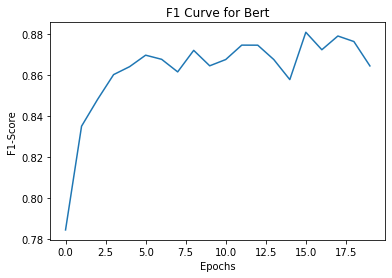

In [50]:
plt.plot(f1score_bert)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve for Bert" )
plt.show()

In [51]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/biobert_v1.0_pubmed_pmc', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [52]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [53]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [54]:
epochs = 20
max_grad_norm = 1.0

train_loss_biobert = []
evaluation_loss_biobert = []
f1score_biobert = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss_biobert.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss_biobert.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score_biobert.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.3077390705063162
Validation loss: 0.07228352501988411
Validation Accuracy: 0.9782886994190706


Epoch:   5%|▌         | 1/20 [02:39<50:32, 159.61s/it]

F1-Score: 0.8027462371270135
Recall: 0.7871569135163128
Train loss: 0.06474441373764904
Validation loss: 0.05304500530473888
Validation Accuracy: 0.9838804587339743


Epoch:  10%|█         | 2/20 [05:18<47:50, 159.47s/it]

F1-Score: 0.8503057697420899
Recall: 0.8393700787401575
Train loss: 0.04599866722997331
Validation loss: 0.0475959696341306
Validation Accuracy: 0.9827630458733975


Epoch:  15%|█▌        | 3/20 [07:57<45:08, 159.34s/it]

F1-Score: 0.8538042066995586
Recall: 0.8240601503759398
Train loss: 0.03551597307520031
Validation loss: 0.0431714808413138
Validation Accuracy: 0.9826175005008012


Epoch:  20%|██        | 4/20 [10:36<42:27, 159.23s/it]

F1-Score: 0.8686073957513769
Recall: 0.8461931527848748
Train loss: 0.028511533959464156
Validation loss: 0.04594886085639397
Validation Accuracy: 0.9814171424278846


Epoch:  25%|██▌       | 5/20 [13:15<39:47, 159.19s/it]

F1-Score: 0.8700265251989389
Recall: 0.8568443051201672
Train loss: 0.022378338666376767
Validation loss: 0.04764642861361305
Validation Accuracy: 0.9812136919070512


Epoch:  30%|███       | 6/20 [15:54<37:08, 159.17s/it]

F1-Score: 0.8722513089005235
Recall: 0.8482688391038696
Train loss: 0.01823774724095283
Validation loss: 0.050973619567230344
Validation Accuracy: 0.9807974008413461


Epoch:  35%|███▌      | 7/20 [18:33<34:28, 159.10s/it]

F1-Score: 0.8681806316888541
Recall: 0.8420253164556962
Train loss: 0.014832757177246267
Validation loss: 0.05050207294213275
Validation Accuracy: 0.983878893729968


Epoch:  40%|████      | 8/20 [21:12<31:48, 159.01s/it]

F1-Score: 0.8757928118393236
Recall: 0.8594398340248963
Train loss: 0.012741833510345192
Validation loss: 0.05467755999416113
Validation Accuracy: 0.9821918194110576


Epoch:  45%|████▌     | 9/20 [23:51<29:09, 159.02s/it]

F1-Score: 0.8707805907172995
Recall: 0.8527892561983471
Train loss: 0.010997283557138596
Validation loss: 0.05564116368380686
Validation Accuracy: 0.9833514873798076


Epoch:  50%|█████     | 10/20 [26:30<26:30, 159.01s/it]

F1-Score: 0.8734243697478992
Recall: 0.8519467213114754
Train loss: 0.009177123567738275
Validation loss: 0.06479011670065422
Validation Accuracy: 0.9809711162860576
F1-Score: 0.8729222520107239


Epoch:  55%|█████▌    | 11/20 [29:09<23:51, 159.03s/it]

Recall: 0.8687299893276414
Train loss: 0.00785569618654689
Validation loss: 0.05950325517915189
Validation Accuracy: 0.9820587940705128


Epoch:  60%|██████    | 12/20 [31:49<21:12, 159.12s/it]

F1-Score: 0.8727462764567546
Recall: 0.8472856418061897
Train loss: 0.007229198879337212
Validation loss: 0.06389342853799462
Validation Accuracy: 0.9803325946514424


Epoch:  65%|██████▌   | 13/20 [34:28<18:34, 159.16s/it]

F1-Score: 0.8697247706422018
Recall: 0.8468606431852986
Train loss: 0.006180358904974438
Validation loss: 0.0677947496684889
Validation Accuracy: 0.977852063301282


Epoch:  70%|███████   | 14/20 [37:07<15:55, 159.21s/it]

F1-Score: 0.8661252292376211
Recall: 0.842937276899541
Train loss: 0.005515811600726787
Validation loss: 0.0712710857236137
Validation Accuracy: 0.9810650165264424


Epoch:  75%|███████▌  | 15/20 [39:47<13:16, 159.25s/it]

F1-Score: 0.8729454735194365
Recall: 0.8462316641375822
Train loss: 0.0048607642409530735
Validation loss: 0.07024140174811085
Validation Accuracy: 0.9795203575721154


Epoch:  80%|████████  | 16/20 [42:26<10:37, 159.28s/it]

F1-Score: 0.875065893516078
Recall: 0.8565531475748194
Train loss: 0.004344131579066481
Validation loss: 0.07107012501607339
Validation Accuracy: 0.9792230068108975


Epoch:  85%|████████▌ | 17/20 [45:05<07:57, 159.28s/it]

F1-Score: 0.8676743569345002
Recall: 0.854308093994778
Train loss: 0.004436108560460813
Validation loss: 0.0723414549138397
Validation Accuracy: 0.9758692032251602


Epoch:  90%|█████████ | 18/20 [47:44<05:18, 159.04s/it]

F1-Score: 0.872872340425532
Recall: 0.8618697478991597
Train loss: 0.0035780110894106506
Validation loss: 0.07423555750089388
Validation Accuracy: 0.9702273637820512


Epoch:  95%|█████████▌| 19/20 [50:22<02:38, 158.88s/it]

F1-Score: 0.8692636072572039
Recall: 0.8609936575052854
Train loss: 0.003500475610829272
Validation loss: 0.0740494051327308
Validation Accuracy: 0.979622082832532


Epoch: 100%|██████████| 20/20 [53:01<00:00, 158.93s/it]

F1-Score: 0.8798735511064278
Recall: 0.8608247422680413


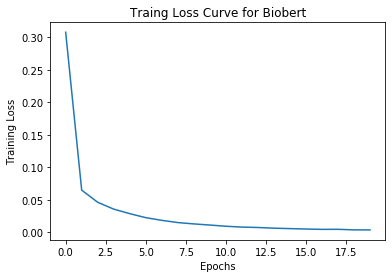

In [55]:
plt.plot(train_loss_biobert)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve for Biobert")
plt.show()

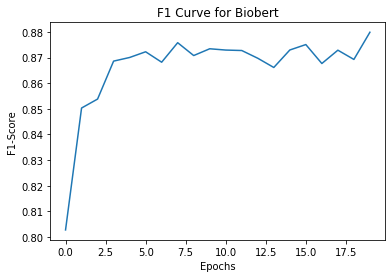

In [56]:
plt.plot(f1score_biobert)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve for Biobert")
plt.show()

In [57]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/scibert_scivocab_cased', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [58]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [59]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [60]:
epochs = 20
max_grad_norm = 1.0

train_loss_scibert = []
evaluation_loss_scibert = []
f1score_scibert = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss_scibert.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss_scibert.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score_scibert.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.5527599752655526
Validation loss: 0.2028418971846501
Validation Accuracy: 0.8882915790264424


Epoch:   5%|▌         | 1/20 [02:39<50:30, 159.51s/it]

F1-Score: 0.5075388540941776
Recall: 0.44562118126272915
Train loss: 0.17147589570255642
Validation loss: 0.12229856320967276
Validation Accuracy: 0.9112173227163461


Epoch:  10%|█         | 2/20 [05:19<47:52, 159.56s/it]

F1-Score: 0.704424778761062
Recall: 0.6636493568365889
Train loss: 0.10341894144624895
Validation loss: 0.09117337238664429
Validation Accuracy: 0.9181549854767628


Epoch:  15%|█▌        | 3/20 [07:58<45:11, 159.47s/it]

F1-Score: 0.763952892985151
Recall: 0.7278048780487805
Train loss: 0.07273721484846979
Validation loss: 0.08682817872613668
Validation Accuracy: 0.9184179061498398


Epoch:  20%|██        | 4/20 [10:37<42:30, 159.40s/it]

F1-Score: 0.7700296735905044
Recall: 0.7116087751371115
Train loss: 0.054147596696118044
Validation loss: 0.07838733525325854
Validation Accuracy: 0.9214978340344552


Epoch:  25%|██▌       | 5/20 [13:16<39:50, 159.34s/it]

F1-Score: 0.7974489795918368
Recall: 0.7572674418604651
Train loss: 0.042055210045658015
Validation loss: 0.07733122476687034
Validation Accuracy: 0.9220283703926282


Epoch:  30%|███       | 6/20 [15:55<37:09, 159.25s/it]

F1-Score: 0.8061302681992336
Recall: 0.7663914521612433
Train loss: 0.03377793307341106
Validation loss: 0.08047139396270116
Validation Accuracy: 0.9218421349158654


Epoch:  35%|███▌      | 7/20 [18:34<34:29, 159.19s/it]

F1-Score: 0.8047307498741822
Recall: 0.7549575070821529
Train loss: 0.027269338862308395
Validation loss: 0.07956527965143323
Validation Accuracy: 0.9237655248397436


Epoch:  40%|████      | 8/20 [21:14<31:50, 159.19s/it]

F1-Score: 0.8152312803475594
Recall: 0.7754010695187166
Train loss: 0.022071432373023003
Validation loss: 0.08327872368196647
Validation Accuracy: 0.9231958633814102


Epoch:  45%|████▌     | 9/20 [23:53<29:10, 159.09s/it]

F1-Score: 0.8089658685685176
Recall: 0.7671497584541063
Train loss: 0.018117310783839057
Validation loss: 0.08811712823808193
Validation Accuracy: 0.9227780073116988


Epoch:  50%|█████     | 10/20 [26:32<26:30, 159.07s/it]

F1-Score: 0.8196973582969993
Recall: 0.7821830641213902
Train loss: 0.015090627624472311
Validation loss: 0.09323425668602188
Validation Accuracy: 0.9233492337740384


Epoch:  55%|█████▌    | 11/20 [29:10<23:51, 159.01s/it]

F1-Score: 0.816516129032258
Recall: 0.7835562159484893
Train loss: 0.012571236700750887
Validation loss: 0.0908964582098027
Validation Accuracy: 0.9223758012820512


Epoch:  60%|██████    | 12/20 [31:49<21:11, 158.92s/it]

F1-Score: 0.8142213319979971
Recall: 0.7605238540692236
Train loss: 0.01106959134583048
Validation loss: 0.09434902295470238
Validation Accuracy: 0.9211629231770834


Epoch:  65%|██████▌   | 13/20 [34:28<18:33, 159.03s/it]

F1-Score: 0.801197306061362
Recall: 0.7459359033906178
Train loss: 0.009453262843553559
Validation loss: 0.10485064672927062
Validation Accuracy: 0.9222099108573718


Epoch:  70%|███████   | 14/20 [37:08<15:54, 159.05s/it]

F1-Score: 0.8095832293486399
Recall: 0.7540678754067875
Train loss: 0.007889992554707374
Validation loss: 0.09969216678291559
Validation Accuracy: 0.9234603490584936


Epoch:  75%|███████▌  | 15/20 [39:47<13:15, 159.08s/it]

F1-Score: 0.8136979299769997
Recall: 0.7739426349052018
Train loss: 0.0072823535938972336
Validation loss: 0.10080665551746885
Validation Accuracy: 0.9240519205729166


Epoch:  80%|████████  | 16/20 [42:26<10:36, 159.11s/it]

F1-Score: 0.8257023933402706
Recall: 0.7982897384305835
Train loss: 0.006158552247307029
Validation loss: 0.10467437530557315
Validation Accuracy: 0.9245824569310898


Epoch:  85%|████████▌ | 17/20 [45:05<07:57, 159.09s/it]

F1-Score: 0.8350326797385622
Recall: 0.8110716099542915
Train loss: 0.005598270175956472
Validation loss: 0.10891305934637785
Validation Accuracy: 0.9244979467147436


Epoch:  90%|█████████ | 18/20 [47:43<05:17, 158.81s/it]

F1-Score: 0.8307210031347964
Recall: 0.8062880324543611
Train loss: 0.005591800835831047
Validation loss: 0.11404181240747373
Validation Accuracy: 0.9236653645833334


Epoch:  95%|█████████▌| 19/20 [50:22<02:38, 158.74s/it]

F1-Score: 0.8216216216216216
Recall: 0.7865943814687038
Train loss: 0.004778945466814678
Validation loss: 0.1094580302014947
Validation Accuracy: 0.9241739908854166


Epoch: 100%|██████████| 20/20 [53:00<00:00, 158.55s/it]

F1-Score: 0.8265306122448978
Recall: 0.7848837209302325


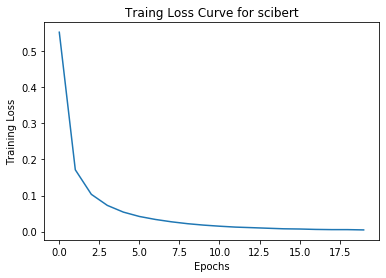

In [61]:
plt.plot(train_loss_scibert)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve for scibert")
plt.show()

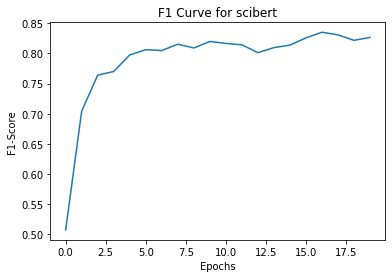

In [62]:
plt.plot(f1score_scibert)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve for scibert")
plt.show()

In [63]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/biobert_pretrain_output_disch_100000', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [64]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=7e-6)

In [65]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [66]:
epochs = 20
max_grad_norm = 1.0

train_loss_clibert_disch = []
evaluation_loss_clibert_disch = []
f1score_clibert_disch = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss_clibert_disch.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss_clibert_disch.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score_clibert_disch.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.6510640522597525
Validation loss: 0.11305577680468559
Validation Accuracy: 0.9531563000801282


Epoch:   5%|▌         | 1/20 [02:38<50:14, 158.68s/it]

F1-Score: 0.6935099337748345
Recall: 0.6821261073475768
Train loss: 0.10004169928236595
Validation loss: 0.06902707663054268
Validation Accuracy: 0.9635072365785257


Epoch:  10%|█         | 2/20 [05:16<47:33, 158.50s/it]

F1-Score: 0.8095621810367983
Recall: 0.807177289769684
Train loss: 0.0700900826726762
Validation loss: 0.05953639963020881
Validation Accuracy: 0.9700943384415064


Epoch:  15%|█▌        | 3/20 [07:55<44:53, 158.46s/it]

F1-Score: 0.8406564319745897
Recall: 0.826222684703434
Train loss: 0.05705277753278825
Validation loss: 0.05246143997646868
Validation Accuracy: 0.97369384765625


Epoch:  20%|██        | 4/20 [10:33<42:14, 158.43s/it]

F1-Score: 0.8489968321013728
Recall: 0.8322981366459627
Train loss: 0.048423375607737434
Validation loss: 0.04942061519250274
Validation Accuracy: 0.975055401141827


Epoch:  25%|██▌       | 5/20 [13:11<39:35, 158.39s/it]

F1-Score: 0.8611552729199788
Recall: 0.8472367049009385
Train loss: 0.04194486696908683
Validation loss: 0.04887028674905499
Validation Accuracy: 0.9768582857572116


Epoch:  30%|███       | 6/20 [15:49<36:56, 158.33s/it]

F1-Score: 0.8605996843766438
Recall: 0.8406988694758479
Train loss: 0.03743974875517507
Validation loss: 0.046398795675486326
Validation Accuracy: 0.9768551557491988


Epoch:  35%|███▌      | 7/20 [18:29<34:22, 158.69s/it]

F1-Score: 0.8616993464052287
Recall: 0.8369730827831386
Train loss: 0.03348900395405801
Validation loss: 0.04584181976194183
Validation Accuracy: 0.9778238932291666


Epoch:  40%|████      | 8/20 [21:08<31:46, 158.88s/it]

F1-Score: 0.8704092339979013
Recall: 0.848159509202454
Train loss: 0.030207875233267154
Validation loss: 0.047366546389336385
Validation Accuracy: 0.9808020958533654


Epoch:  45%|████▌     | 9/20 [23:48<29:09, 159.04s/it]

F1-Score: 0.8691539674198634
Recall: 0.8482051282051282
Train loss: 0.027328062166958624
Validation loss: 0.04757393392113348
Validation Accuracy: 0.981532952724359


Epoch:  50%|█████     | 10/20 [26:27<26:30, 159.07s/it]

F1-Score: 0.8682008368200838
Recall: 0.8434959349593496
Train loss: 0.024281297249816605
Validation loss: 0.04687818846044441
Validation Accuracy: 0.9809539012419872


Epoch:  55%|█████▌    | 11/20 [29:05<23:50, 158.92s/it]

F1-Score: 0.8768289438680501
Recall: 0.8660010509721492
Train loss: 0.02173314786017365
Validation loss: 0.04884396477912863
Validation Accuracy: 0.9821213942307692


Epoch:  60%|██████    | 12/20 [31:44<21:10, 158.81s/it]

F1-Score: 0.871578947368421
Recall: 0.8518518518518519
Train loss: 0.01920029187301324
Validation loss: 0.048445106173555054
Validation Accuracy: 0.9819163787059294


Epoch:  65%|██████▌   | 13/20 [34:23<18:32, 158.97s/it]

F1-Score: 0.8672382436996623
Recall: 0.8374310085298545
Train loss: 0.017820493616075454
Validation loss: 0.05194191619132956
Validation Accuracy: 0.9830776116786858


Epoch:  70%|███████   | 14/20 [37:03<15:55, 159.17s/it]

F1-Score: 0.8769682412596744
Recall: 0.8688524590163934
Train loss: 0.01580958837484367
Validation loss: 0.052211853597934045
Validation Accuracy: 0.9833827874599358


Epoch:  75%|███████▌  | 15/20 [39:43<13:16, 159.34s/it]

F1-Score: 0.874242024782494
Recall: 0.8559628291171916
Train loss: 0.014343943862880081
Validation loss: 0.052985894648979105
Validation Accuracy: 0.9831386468349358


Epoch:  80%|████████  | 16/20 [42:22<10:37, 159.37s/it]

F1-Score: 0.8723404255319149
Recall: 0.8413413413413413
Train loss: 0.013228835519270803
Validation loss: 0.056398425018414855
Validation Accuracy: 0.9826910556891025


Epoch:  85%|████████▌ | 17/20 [45:02<07:58, 159.38s/it]

F1-Score: 0.8638232271325796
Recall: 0.8256385068762279
Train loss: 0.011958439713035009
Validation loss: 0.055667236602554716
Validation Accuracy: 0.9835752829527243


Epoch:  90%|█████████ | 18/20 [47:41<05:18, 159.30s/it]

F1-Score: 0.8729573010015814
Recall: 0.8544891640866873
Train loss: 0.010848059112612175
Validation loss: 0.056661655815939106
Validation Accuracy: 0.9831996819911858


Epoch:  95%|█████████▌| 19/20 [50:20<02:39, 159.26s/it]

F1-Score: 0.8714211348256117
Recall: 0.8429003021148036
Train loss: 0.00998719550351396
Validation loss: 0.0581447339306275
Validation Accuracy: 0.9819695888421475


Epoch: 100%|██████████| 20/20 [52:59<00:00, 159.25s/it]

F1-Score: 0.8729368614094838
Recall: 0.8495665476797553


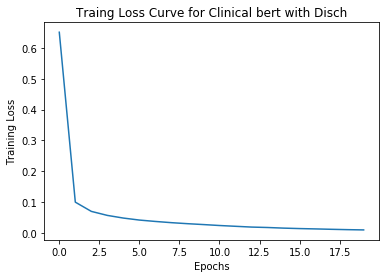

In [67]:
plt.plot(train_loss_clibert_disch)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve for Clinical bert with Disch")
plt.show()

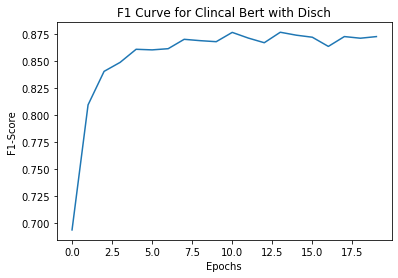

In [68]:
plt.plot(f1score_clibert_disch)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve for Clincal Bert with Disch")
plt.show()

In [69]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/biobert_pretrain_output_all_notes_150000', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [70]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=9e-6)

In [71]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [72]:
epochs = 20
max_grad_norm = 1.0

train_loss_clibert_notes = []
evaluation_loss_clibert_notes = []
f1score_clibert_notes = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss_clibert_notes.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss_clibert_notes.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score_clibert_notes.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.5275041509013605
Validation loss: 0.1055387690042456
Validation Accuracy: 0.9697281275040064


Epoch:   5%|▌         | 1/20 [02:39<50:35, 159.78s/it]

F1-Score: 0.7086573354069466
Recall: 0.6828171828171828
Train loss: 0.09399809352877016
Validation loss: 0.06601646573593219
Validation Accuracy: 0.9790101662660257


Epoch:  10%|█         | 2/20 [05:19<47:54, 159.68s/it]

F1-Score: 0.8157546920433518
Recall: 0.8007265179034769
Train loss: 0.0663793326148066
Validation loss: 0.056932599594195686
Validation Accuracy: 0.9806377704326924


Epoch:  15%|█▌        | 3/20 [07:58<45:14, 159.70s/it]

F1-Score: 0.8305128872689402
Recall: 0.8035264483627204
Train loss: 0.05385396593378336
Validation loss: 0.05192761557797591
Validation Accuracy: 0.982692620693109


Epoch:  20%|██        | 4/20 [10:38<42:33, 159.59s/it]

F1-Score: 0.8501833420639079
Recall: 0.827217125382263
Train loss: 0.04592639964374038
Validation loss: 0.053966337659706674
Validation Accuracy: 0.9819914988982372


Epoch:  25%|██▌       | 5/20 [13:17<39:52, 159.52s/it]

F1-Score: 0.8241456722374657
Recall: 0.7673014398513702
Train loss: 0.03962153977586477
Validation loss: 0.0476379736016194
Validation Accuracy: 0.9835565029046475


Epoch:  30%|███       | 6/20 [15:57<37:13, 159.54s/it]

F1-Score: 0.848170256942642
Recall: 0.8182273410115173
Train loss: 0.03354864168506098
Validation loss: 0.046155081363394856
Validation Accuracy: 0.9843186598557692


Epoch:  35%|███▌      | 7/20 [18:36<34:33, 159.52s/it]

F1-Score: 0.8624283480979678
Recall: 0.8350151362260343
Train loss: 0.029280141587435353
Validation loss: 0.04626383430634936
Validation Accuracy: 0.9848069411057692


Epoch:  40%|████      | 8/20 [21:16<31:54, 159.52s/it]

F1-Score: 0.8689217758985202
Recall: 0.8526970954356846
Train loss: 0.02665548271089086
Validation loss: 0.04782609439765414
Validation Accuracy: 0.9848476312099358


Epoch:  45%|████▌     | 9/20 [23:55<29:14, 159.49s/it]

F1-Score: 0.8681722689075629
Recall: 0.8468237704918032
Train loss: 0.023090463332496407
Validation loss: 0.049318740610033274
Validation Accuracy: 0.9833733974358975


Epoch:  50%|█████     | 10/20 [26:35<26:34, 159.50s/it]

F1-Score: 0.8585543421736869
Recall: 0.8296482412060302
Train loss: 0.02016169905565432
Validation loss: 0.049013054774453245
Validation Accuracy: 0.9833217523036858


Epoch:  55%|█████▌    | 11/20 [29:14<23:54, 159.44s/it]

F1-Score: 0.8582534335320031
Recall: 0.8267598602096855
Train loss: 0.017995408356578146
Validation loss: 0.04963192087598145
Validation Accuracy: 0.9848773662860576


Epoch:  60%|██████    | 12/20 [31:54<21:15, 159.49s/it]

F1-Score: 0.8737812911725955
Recall: 0.8550799381124291
Train loss: 0.015597793588114646
Validation loss: 0.05319741601124406
Validation Accuracy: 0.9854360727163461


Epoch:  65%|██████▌   | 13/20 [34:33<18:36, 159.49s/it]

F1-Score: 0.869381279746166
Recall: 0.8535825545171339
Train loss: 0.014209595441562233
Validation loss: 0.052829437578717865
Validation Accuracy: 0.9855377979767628


Epoch:  70%|███████   | 14/20 [37:13<15:56, 159.46s/it]

F1-Score: 0.8741442864665613
Recall: 0.854788877445932
Train loss: 0.012222140768136812
Validation loss: 0.057238784696285926
Validation Accuracy: 0.9850917718349358


Epoch:  75%|███████▌  | 15/20 [39:52<13:16, 159.35s/it]

F1-Score: 0.8708487084870848
Recall: 0.8524251805985552
Train loss: 0.01140881492314922
Validation loss: 0.05967175727710128
Validation Accuracy: 0.9846739157652243


Epoch:  80%|████████  | 16/20 [42:31<10:37, 159.34s/it]

F1-Score: 0.8728813559322035
Recall: 0.8583333333333333
Train loss: 0.010146766683634071
Validation loss: 0.06197675752143065
Validation Accuracy: 0.9845002003205128


Epoch:  85%|████████▌ | 17/20 [45:10<07:57, 159.16s/it]

F1-Score: 0.8689655172413794
Recall: 0.8557993730407524
Train loss: 0.008972222001735404
Validation loss: 0.060428587875018515
Validation Accuracy: 0.9844501201923076


Epoch:  90%|█████████ | 18/20 [47:48<05:18, 159.05s/it]

F1-Score: 0.8696109358569927
Recall: 0.8490759753593429
Train loss: 0.008200899527906948
Validation loss: 0.06150652305223048
Validation Accuracy: 0.9846332256610576


Epoch:  95%|█████████▌| 19/20 [50:28<02:39, 159.16s/it]

F1-Score: 0.8657419523684899
Recall: 0.8417302798982188
Train loss: 0.0077768148218780335
Validation loss: 0.06522422353737056
Validation Accuracy: 0.9834735576923076


Epoch: 100%|██████████| 20/20 [53:07<00:00, 159.30s/it]

F1-Score: 0.8692913385826772
Recall: 0.8474923234390993


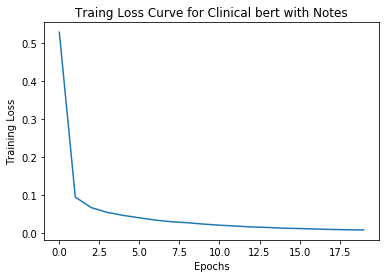

In [73]:
plt.plot(train_loss_clibert_notes)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve for Clinical bert with Notes")
plt.show()

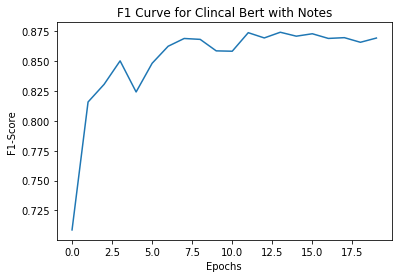

In [74]:
plt.plot(f1score_clibert_notes)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve for Clincal Bert with Notes")
plt.show()

In [75]:
x = list(range(1,21))
print(x)
y1 = [f1score_bert, f1score_biobert, f1score_scibert, f1score_clibert_disch, f1score_clibert_notes]
y = list(zip(f1score_bert, f1score_biobert, f1score_scibert, f1score_clibert_disch, f1score_clibert_notes))
print(y)
print(y1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[(0.7843031123139377, 0.8027462371270135, 0.5075388540941776, 0.6935099337748345, 0.7086573354069466), (0.8350240256273358, 0.8503057697420899, 0.704424778761062, 0.8095621810367983, 0.8157546920433518), (0.8481210855949896, 0.8538042066995586, 0.763952892985151, 0.8406564319745897, 0.8305128872689402), (0.860249270750464, 0.8686073957513769, 0.7700296735905044, 0.8489968321013728, 0.8501833420639079), (0.8641390205371249, 0.8700265251989389, 0.7974489795918368, 0.8611552729199788, 0.8241456722374657), (0.8697501329080277, 0.8722513089005235, 0.8061302681992336, 0.8605996843766438, 0.848170256942642), (0.8677248677248677, 0.8681806316888541, 0.8047307498741822, 0.8616993464052287, 0.8624283480979678), (0.8615782664941786, 0.8757928118393236, 0.8152312803475594, 0.8704092339979013, 0.8689217758985202), (0.8721084817867588, 0.8707805907172995, 0.8089658685685176, 0.8691539674198634, 0.8681722689075629), (0.8645533141

In [4]:
x = list(range(1,21))
y = [(0.7843031123139377, 0.8027462371270135, 0.5075388540941776, 0.6935099337748345, 0.7086573354069466), (0.8350240256273358, 0.8503057697420899, 0.704424778761062, 0.8095621810367983, 0.8157546920433518), (0.8481210855949896, 0.8538042066995586, 0.763952892985151, 0.8406564319745897, 0.8305128872689402), (0.860249270750464, 0.8686073957513769, 0.7700296735905044, 0.8489968321013728, 0.8501833420639079), (0.8641390205371249, 0.8700265251989389, 0.7974489795918368, 0.8611552729199788, 0.8241456722374657), (0.8697501329080277, 0.8722513089005235, 0.8061302681992336, 0.8605996843766438, 0.848170256942642), (0.8677248677248677, 0.8681806316888541, 0.8047307498741822, 0.8616993464052287, 0.8624283480979678), (0.8615782664941786, 0.8757928118393236, 0.8152312803475594, 0.8704092339979013, 0.8689217758985202), (0.8721084817867588, 0.8707805907172995, 0.8089658685685176, 0.8691539674198634, 0.8681722689075629), (0.8645533141210373, 0.8734243697478992, 0.8196973582969993, 0.8682008368200838, 0.8585543421736869), (0.8676202860858258, 0.8729222520107239, 0.816516129032258, 0.8768289438680501, 0.8582534335320031), (0.8746666666666666, 0.8727462764567546, 0.8142213319979971, 0.871578947368421, 0.8737812911725955), (0.8746371074162047, 0.8697247706422018, 0.801197306061362, 0.8672382436996623, 0.869381279746166), (0.8676160337552742, 0.8661252292376211, 0.8095832293486399, 0.8769682412596744, 0.8741442864665613), (0.8578052550231839, 0.8729454735194365, 0.8136979299769997, 0.874242024782494, 0.8708487084870848), (0.8809651474530831, 0.875065893516078, 0.8257023933402706, 0.8723404255319149, 0.8728813559322035), (0.872408293460925, 0.8676743569345002, 0.8350326797385622, 0.8638232271325796, 0.8689655172413794), (0.8791267305644302, 0.872872340425532, 0.8307210031347964, 0.8729573010015814, 0.8696109358569927), (0.8764223339507806, 0.8692636072572039, 0.8216216216216216, 0.8714211348256117, 0.8657419523684899), (0.8644957983193278, 0.8798735511064278, 0.8265306122448978, 0.8729368614094838, 0.8692913385826772)]

[0.7843031123139377, 0.8350240256273358, 0.8481210855949896, 0.860249270750464, 0.8641390205371249, 0.8697501329080277, 0.8677248677248677, 0.8615782664941786, 0.8721084817867588, 0.8645533141210373, 0.8676202860858258, 0.8746666666666666, 0.8746371074162047, 0.8676160337552742, 0.8578052550231839, 0.8809651474530831, 0.872408293460925, 0.8791267305644302, 0.8764223339507806, 0.8644957983193278]
[0.8027462371270135, 0.8503057697420899, 0.8538042066995586, 0.8686073957513769, 0.8700265251989389, 0.8722513089005235, 0.8681806316888541, 0.8757928118393236, 0.8707805907172995, 0.8734243697478992, 0.8729222520107239, 0.8727462764567546, 0.8697247706422018, 0.8661252292376211, 0.8729454735194365, 0.875065893516078, 0.8676743569345002, 0.872872340425532, 0.8692636072572039, 0.8798735511064278]
[0.5075388540941776, 0.704424778761062, 0.763952892985151, 0.7700296735905044, 0.7974489795918368, 0.8061302681992336, 0.8047307498741822, 0.8152312803475594, 0.8089658685685176, 0.8196973582969993, 0.8

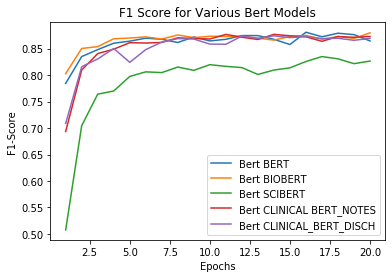

In [6]:
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Score for Various Bert Models")
for i in range(len(y[0])):
    print ([pt[i] for pt in y])
    label = ['BERT', 'BIOBERT', 'SCIBERT', 'CLINICAL BERT_NOTES', 'CLINICAL_BERT_DISCH']
    plt.plot(x,[pt[i] for pt in y],label = 'Bert %s'%label[i])
plt.legend()
plt.show()